In [1]:
#encoding='utf-8'
import pandas as pd
import requests
import json
import time
import talib
import numpy as np

In [2]:
huobi_granularity_dict={60:"1min",300:"5min",900:"15min",1800:"30min",3600:"60min",
                       14400:"4hour",86400:"1day",604800:"1week",2592000:"mon",
                       94608000:"1year"}
symbol="eth_usdt"

In [3]:
data=requests.get("https://api.huobi.fm/market/history/kline?period={}&size=2000&symbol={}".format(huobi_granularity_dict[86400],symbol.replace("_","")))

In [4]:
data=json.loads(data.content.decode())

In [5]:
data_list=[]
for i in data['data'][::-1]:
    data_dict={'time':time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(i['id'])),
               'open':i['open'],
               'close':i['close'],
               'low':i['low'],
               'high':i['high']}
    data_list.append(data_dict)
df=pd.DataFrame(data_list)

In [6]:
close_array=np.array(df['close'].values.tolist()) #获取收盘价数组

In [7]:
df['ama_10']=talib.KAMA(close_array,10)

In [8]:
df['ama_100']=talib.KAMA(close_array,100)

In [9]:
df['return']=np.log(df['close']/df['close'].shift())

In [10]:
df['position']=np.where(df['ama_10']>df['ama_100'],1,0)

In [11]:
df['strategy_kama']=df['position'].shift(1)*df['return']

<AxesSubplot:>

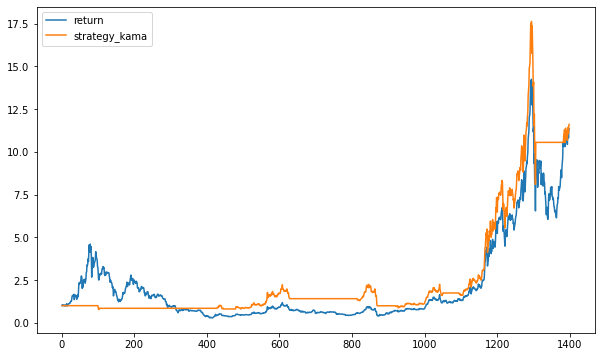

In [12]:
df[['return','strategy_kama']].cumsum().apply(np.exp).plot(figsize=(10,6))

In [13]:
df['HH'] = df['high'].rolling(20).max()

In [14]:
high_array=np.array(df['high'].values.tolist())
low_array=np.array(df['low'].values.tolist())

In [15]:
atr = talib.ATR(high_array, low_array, close_array, timeperiod=14)

In [16]:
df['ATR']=atr

In [17]:
df['stopPrice'] = df['HH'] - 2 * df['ATR']

In [18]:
df['ATRSTOP']=np.where(df['close']>df['stopPrice'],1,0)

In [19]:
df['position_2']=np.where(df['position']&df['ATRSTOP'],1,0)

In [20]:
df['kama_strategy_return']=df['position_2'].shift(1)*df['return']

In [21]:
df

,time,open,close,low,high,ama_10,ama_100,return,position,strategy_kama,HH,ATR,stopPrice,ATRSTOP,position_2,kama_strategy_return
0,2017-10-26 00:00:00,230.00,294.09,230.00,299.40,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,NaN
1,2017-10-27 00:00:00,296.36,299.00,292.48,300.00,NaN,NaN,0.016558,0,0.000000,NaN,NaN,NaN,0,0,0.000000
2,2017-10-28 00:00:00,294.00,292.11,290.00,299.00,NaN,NaN,-0.023313,0,-0.000000,NaN,NaN,NaN,0,0,-0.000000
3,2017-10-29 00:00:00,292.16,308.00,290.60,311.50,NaN,NaN,0.052969,0,0.000000,NaN,NaN,NaN,0,0,0.000000
4,2017-10-30 00:00:00,309.41,305.53,302.00,311.00,NaN,NaN,-0.008052,0,-0.000000,NaN,NaN,NaN,0,0,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394,2021-08-20 00:00:00,3067.22,3283.50,3022.07,3300.92,3071.223731,2791.106338,0.068138,1,0.068138,3334.83,204.647216,2925.535567,1,1,0.068138
1395,2021-08-21 00:00:00,3283.49,3271.30,3218.72,3309.23,3072.509133,2794.836186,-0.003722,1,-0.003722,3334.83,196.494558,2941.840884,1,1,-0.003722
1396,2021-08-22 00:00:00,3271.31,3180.75,3153.53,3291.67,3075.502165,2799.737305,-0.028070,1,-0.028070,3334.83,192.326375,2950.177250,1,1,-0.028070
1397,2021-08-23 00:00:00,3180.75,3325.72,3125.21,3376.49,3080.600807,2804.251671,0.044569,1,0.044569,3376.49,196.537348,2983.415303,1,1,0.044569


<AxesSubplot:>

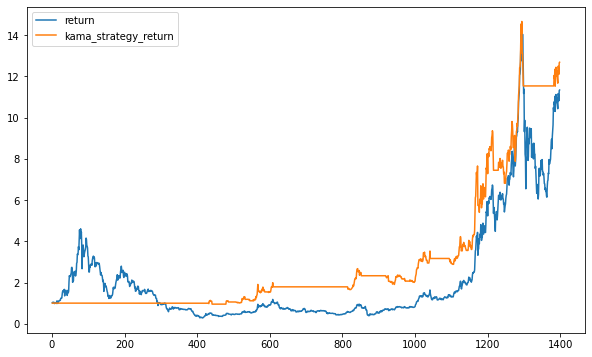

In [22]:
df[['return','kama_strategy_return']].cumsum().apply(np.exp).plot(figsize=(10,6))

In [33]:
df

,time,open,close,low,high,ama_10,ama_100,return,position,strategy_kama,HH,ATR,stopPrice,ATRSTOP,position_2,kama_strategy_return
0,2017-10-26 00:00:00,230.00,294.09,230.00,299.40,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,NaN
1,2017-10-27 00:00:00,296.36,299.00,292.48,300.00,NaN,NaN,0.016558,0,0.000000,NaN,NaN,NaN,0,0,0.000000
2,2017-10-28 00:00:00,294.00,292.11,290.00,299.00,NaN,NaN,-0.023313,0,-0.000000,NaN,NaN,NaN,0,0,-0.000000
3,2017-10-29 00:00:00,292.16,308.00,290.60,311.50,NaN,NaN,0.052969,0,0.000000,NaN,NaN,NaN,0,0,0.000000
4,2017-10-30 00:00:00,309.41,305.53,302.00,311.00,NaN,NaN,-0.008052,0,-0.000000,NaN,NaN,NaN,0,0,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394,2021-08-20 00:00:00,3067.22,3283.50,3022.07,3300.92,3071.223731,2791.106338,0.068138,1,0.068138,3334.83,204.647216,2925.535567,1,1,0.068138
1395,2021-08-21 00:00:00,3283.49,3271.30,3218.72,3309.23,3072.509133,2794.836186,-0.003722,1,-0.003722,3334.83,196.494558,2941.840884,1,1,-0.003722
1396,2021-08-22 00:00:00,3271.31,3180.75,3153.53,3291.67,3075.502165,2799.737305,-0.028070,1,-0.028070,3334.83,192.326375,2950.177250,1,1,-0.028070
1397,2021-08-23 00:00:00,3180.75,3325.72,3125.21,3376.49,3080.600807,2804.251671,0.044569,1,0.044569,3376.49,196.537348,2983.415303,1,1,0.044569


In [23]:
#回测比较好的交易对
#BTC，ETH，hc，glm，xmr,lamb,hpt,omg,xem,akro,neo

In [24]:
# def cal_profit(symbol):
#     data=requests.get("https://api.huobi.fm/market/history/kline?period={}&size=2000&symbol={}".format(huobi_granularity_dict[86400],symbol.replace("_","")))
#     data=json.loads(data.content.decode())
#     profit=0
#     try:
#         data_list=[]
#         for i in data['data'][::-1]:
#             data_dict={'time':time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(i['id'])),
#                        'open':i['open'],
#                        'close':i['close'],
#                        'low':i['low'],
#                        'high':i['high']}
#             data_list.append(data_dict)
#         df=pd.DataFrame(data_list)
#         close_array=np.array(df['close'].values.tolist()) #获取收盘价数组
#         high_array=np.array(df['high'].values.tolist())
#         low_array=np.array(df['low'].values.tolist())
#         df['HH'] = df['high'].rolling(20).max()
#         df['ama_10']=talib.KAMA(close_array,10)
#         df['ama_100']=talib.KAMA(close_array,100)
#         df['atr'] = talib.ATR(high_array, low_array, close_array, timeperiod=14)
#         df['stopPrice'] = df['HH'] - 3 * df['atr']
#         df['ATRSTOP']=np.where(df['close']>df['stopPrice'],1,0)
#         df['return']=np.log(df['close']/df['close'].shift())
#         df['position']=np.where(df['ama_10']>df['ama_100'],1,0)
#         df['position_2']=np.where(df['position']&df['ATRSTOP'],1,0)
#         df['strategy_kama']=df['position_2'].shift(1)*df['return']
#         profit=np.exp(df['strategy_kama'].sum())
#         print('交易对{}回测，利润{}'.format(symbol,profit))
#     except Exception as e:
#         print('交易对{}获取数据失败，无法回测'.format(symbol))
#     finally:
#         return profit

In [25]:
#cal_profit('btc_usdt')

In [26]:
symbols = ['firo_usdt', 'ruff_usdt', 'em_usdt', 'hc_usdt', 'glm_usdt', 'wtc_usdt', 'xtz_usdt', 'xmr_usdt',
           'badger_usdt', 'algo_usdt', 'woo_usdt', 'wicc_usdt', 'chr_usdt', 'zrx_usdt',
           'arpa_usdt', 'pha_usdt', 'avax_usdt', 'tnb_usdt', 'mdx_usdt', 'lamb_usdt',
           'rsr_usdt', 'tt_usdt', 'uma_usdt', 'dash_usdt', 'xlm_usdt', 'sun_usdt', 'wnxm_usdt', 'hpt_usdt',
           'omg_usdt', 'matic_usdt', 'ant_usdt', 'bot_usdt', 'loom_usdt', 'uni_usdt', 'crv_usdt', 'mx_usdt',
           'xem_usdt', 'eos_usdt', 'kava_usdt', 'new_usdt', 'akro_usdt', 'act_usdt', 'blz_usdt', 'waves_usdt',
           'snt_usdt', 'btt_usdt', 'egt_usdt', 'dcr_usdt', 'vsys_usdt', 'iost_usdt', 'itc_usdt', 'smt_usdt',
           'chz_usdt', 'node_usdt', 'soc_usdt', 'btm_usdt', 'sol_usdt', 'trx_usdt', 'fsn_usdt', 'neo_usdt',
           'qtum_usdt', 'fis_usdt', 'elf_usdt', 'knc_usdt', 'lba_usdt', 'theta_usdt', 'kan_usdt', 'comp_usdt',
           'cmt_usdt', 'hit_usdt', 'ksm_usdt', 'bts_usdt', 'for_usdt', 'lrc_usdt', 'ring_usdt', 'xrp_usdt',
           'storj_usdt', 'nest_usdt', 'yfi_usdt', 'dot_usdt', 'fil_usdt', 'ar_usdt', 'let_usdt', 'cnns_usdt',
           'ogo_usdt', 'dta_usdt', 'bal_usdt', 'zen_usdt', 'luna_usdt', 'btc1s_usdt', 'zil_usdt', 'dock_usdt',
           'pols_usdt', 'ctxc_usdt', 'snx_usdt', 'atp_usdt', 'bags_usdt', 'swftc_usdt', 'inj_usdt', 'beth_usdt',
           'grt_usdt', 'skm_usdt', 'steem_usdt', 'ankr_usdt', 'bnt_usdt', 'zec_usdt', 'top_usdt', 'bsv_usdt',
           'hive_usdt', 'cvc_usdt', 'bat_usdt', 'lend_usdt', 'gt_usdt', 'ach_usdt', 'nkn_usdt', 'mln_usdt',
           'pai_usdt', 'wxt_usdt', 'mkr_usdt', 'cro_usdt', 'mana_usdt', 'btc_usdt', 'bix_usdt', 'nas_usdt',
           'hbar_usdt', 'waxp_usdt', 'link_usdt', 'mds_usdt', 'sand_usdt', 'band_usdt', 'trb_usdt', 'gnx_usdt',
           'ocn_usdt', 'sushi_usdt', 'icx_usdt', 'utk_usdt', 'bch_usdt', 'ckb_usdt', 'etc_usdt',
           'ela_usdt', 'yee_usdt', 'one_usdt', 'lol_usdt', 'near_usdt', 'yfii_usdt',
           'aave_usdt', 'ht_usdt', '1inch_usdt', 'hbc_usdt', 'nbs_usdt',
           'bhd_usdt', 'skl_usdt', 'ont_usdt', 'gxc_usdt', 'oxt_usdt', 'rvn_usdt', 'iotx_usdt',
           'ftt_usdt', 'atom_usdt', 'nuls_usdt', 'pvt_usdt', 'stpt_usdt', 'flow_usdt', 'jst_usdt',
           'df_usdt', 'eth1s_usdt', 'pond_usdt', 'nexo_usdt', 'iota_usdt', 'vidy_usdt',
           'mass_usdt', 'abt_usdt', 'ltc_usdt', 'ast_usdt', 'ogn_usdt', 'cre_usdt',
           'iris_usdt', 'nano_usdt', 'vet_usdt', 'doge_usdt', 'ada_usdt', 'eth_usdt',
           ]

In [27]:
# profit_dict={}
# for symbol in symbols:
#     profit=cal_profit(symbol)
#     profit_dict[symbol]=profit

In [28]:
# profit_dict

In [29]:
#sorted(profit_dict.items(), key=lambda item:item[1],reverse=True)

In [30]:
#回测比较好的交易对
#BTC，ETH，hc，glm，xmr,lamb,hpt,omg,xem,akro,neo,luna,vet,gt,ada,nkn,hit,etc,ht,bix,hpt,one,hc,storj,chr,uni,sushi,xmr
#回测收益较高的交易对
#hbc,theta,luna,vet,gt,akro,ada,eth,ftt,nkn,link,hit,xem,etc,mana,rsr,omg,ht,bix,woo,hpt,chz,one,dock,hc,storj,btt,chr,uni,for,sushi,xmr,btc

In [31]:
# [('hbc_usdt', 111.76282611137566),
#  ('theta_usdt', 27.016047958959895),
#  ('luna_usdt', 26.889405763175194),
#  ('vet_usdt', 25.984546408374015),
#  ('gt_usdt', 23.176113123613582),
#  ('akro_usdt', 23.050280670163943),
#  ('ada_usdt', 20.12395221259766),
#  ('eth_usdt', 17.388222845447764),
#  ('ftt_usdt', 15.831915933277028),
#  ('nkn_usdt', 15.20301652484763),
#  ('link_usdt', 14.892501312450475),
#  ('hit_usdt', 14.702984304965689),
#  ('xem_usdt', 13.110053046606154),
#  ('etc_usdt', 12.973746806111023),
#  ('mana_usdt', 12.040192781991285),
#  ('rsr_usdt', 11.047212928593806),
#  ('omg_usdt', 10.807083380238774),
#  ('ht_usdt', 9.460372170322923),
#  ('bix_usdt', 9.423824050490017),
#  ('woo_usdt', 9.194668087224969),
#  ('hpt_usdt', 8.779583540554281),
#  ('chz_usdt', 8.63440119222506),
#  ('one_usdt', 8.409602502895364),
#  ('dock_usdt', 7.812932819137709),
#  ('hc_usdt', 7.725124534366257),
#  ('storj_usdt', 7.712191402477974),
#  ('btt_usdt', 7.6353209240168125),
#  ('chr_usdt', 6.809393400486323),
#  ('uni_usdt', 6.516538950784998),
#  ('for_usdt', 6.487042720898218),
#  ('sushi_usdt', 6.3235915610086515),
#  ('xmr_usdt', 6.151567212299684),
#  ('btc_usdt', 6.094898682281554),
#  ('rvn_usdt', 5.672632139628941),
#  ('ankr_usdt', 5.294918477774782),
#  ('ogn_usdt', 5.238393317971957),
#  ('lamb_usdt', 5.237529080971403),
#  ('vidy_usdt', 5.050278249435969),
#  ('qtum_usdt', 4.995751376257516),
#  ('ltc_usdt', 4.807392724314639),
#  ('sand_usdt', 4.800100718112166),
#  ('ocn_usdt', 4.775344474783668),
#  ('wtc_usdt', 4.718658037323078),
#  ('ksm_usdt', 4.509265454632377),
#  ('ar_usdt', 4.413583613729647),
#  ('glm_usdt', 4.400470941064288),
#  ('nano_usdt', 4.229156032890856),
#  ('neo_usdt', 4.025386287116943),
#  ('pai_usdt', 4.007944983804751),
#  ('egt_usdt', 3.8960208990087843),
#  ('atom_usdt', 3.8558813024415115),
#  ('new_usdt', 3.8492941274360706),
#  ('iris_usdt', 3.75756777064506),
#  ('cro_usdt', 3.6645603643218307),
#  ('lba_usdt', 3.5360424362668863),
#  ('snt_usdt', 3.4466170538626604),
#  ('nexo_usdt', 3.351418438320739),
#  ('xlm_usdt', 3.3247807069630313),
#  ('waves_usdt', 3.262960030406456),
#  ('ckb_usdt', 3.053198285678269),
#  ('comp_usdt', 2.992790889144489),
#  ('doge_usdt', 2.9087628972223185),
#  ('fil_usdt', 2.8686522761140916),
#  ('dash_usdt', 2.806693033021162),
#  ('bat_usdt', 2.805412337148806),
#  ('gxc_usdt', 2.7835655754096216),
#  ('algo_usdt', 2.7716432239001643),
#  ('dta_usdt', 2.7593233664771186),
#  ('mds_usdt', 2.6827133734855235),
#  ('arpa_usdt', 2.663734364053024),
#  ('snx_usdt', 2.6602019722290025),
#  ('ela_usdt', 2.6230072989640614),
#  ('cre_usdt', 2.5994509845202116),
#  ('ring_usdt', 2.594216395388563),
#  ('zil_usdt', 2.5678378632192507),
#  ('skm_usdt', 2.538839751793171),
#  ('trx_usdt', 2.5318600573789913),
#  ('bnt_usdt', 2.5145286964007183),
#  ('pha_usdt', 2.5097695098834496),
#  ('elf_usdt', 2.3946874824820545),
#  ('mkr_usdt', 2.3848718139594984),
#  ('jst_usdt', 2.2936229959349084),
#  ('soc_usdt', 2.269900210064614),
#  ('act_usdt', 2.218225687876964),
#  ('dot_usdt', 2.1838802438835208),
#  ('zec_usdt', 2.180063281064671),
#  ('lrc_usdt', 2.1757296973722178),
#  ('kan_usdt', 2.1040305395641563),
#  ('cvc_usdt', 2.1035780788299157),
#  ('loom_usdt', 2.0978175545677247),
#  ('tt_usdt', 2.0600008936802863),
#  ('xtz_usdt', 2.0565395654391545),
#  ('eos_usdt', 2.0247223814234503),
#  ('dcr_usdt', 2.0180624661024025),
#  ('node_usdt', 1.9519969874048135),
#  ('avax_usdt', 1.9107888421120112),
#  ('mx_usdt', 1.9012091673818357),
#  ('tnb_usdt', 1.839564123040959),
#  ('iota_usdt', 1.8384417018894292),
#  ('bal_usdt', 1.837650264081408),
#  ('itc_usdt', 1.8133037020745797),
#  ('matic_usdt', 1.7565100652499055),
#  ('nuls_usdt', 1.7541297343686681),
#  ('stpt_usdt', 1.7324001374879485),
#  ('ctxc_usdt', 1.7033476329862827),
#  ('ach_usdt', 1.688219414462623),
#  ('iost_usdt', 1.6846083664247251),
#  ('trb_usdt', 1.666285737175622),
#  ('waxp_usdt', 1.6619661004926778),
#  ('ast_usdt', 1.565891656085382),
#  ('lol_usdt', 1.5658320854061443),
#  ('bsv_usdt', 1.5099927701606686),
#  ('icx_usdt', 1.4372230396389496),
#  ('hive_usdt', 1.3994046634887654),
#  ('bhd_usdt', 1.330162634861356),
#  ('firo_usdt', 1.3179410919580201),
#  ('vsys_usdt', 1.2954103535385744),
#  ('crv_usdt', 1.2911738610984944),
#  ('uma_usdt', 1.2741492734457727),
#  ('df_usdt', 1.260529561349203),
#  ('bch_usdt', 1.2554372069551187),
#  ('beth_usdt', 1.2534650399582121),
#  ('swftc_usdt', 1.2513831745895676),
#  ('top_usdt', 1.2460772412824008),
#  ('wicc_usdt', 1.1891461463492243),
#  ('ont_usdt', 1.1821355796569535),
#  ('em_usdt', 1.1732677470959956),
#  ('blz_usdt', 1.1649457842032493),
#  ('smt_usdt', 1.1496494381348201),
#  ('ant_usdt', 1.1254473224134907),
#  ('cmt_usdt', 1.1145560210533112),
#  ('sol_usdt', 1.0916300355844797),
#  ('wxt_usdt', 1.0685662661585138),
#  ('ruff_usdt', 1.062243234712646),
#  ('near_usdt', 1.05611391864631),
#  ('bts_usdt', 1.0481239356518834),
#  ('hbar_usdt', 1.0462036776263741),
#  ('mdx_usdt', 1.0),
#  ('sun_usdt', 1.0),
#  ('bags_usdt', 1.0),
#  ('inj_usdt', 1.0),
#  ('oxt_usdt', 1.0),
#  ('iotx_usdt', 1.0),
#  ('flow_usdt', 1.0),
#  ('pond_usdt', 1.0),
#  ('mass_usdt', 1.0),
#  ('knc_usdt', 0.9882618460069346),
#  ('utk_usdt', 0.9845397781367797),
#  ('mln_usdt', 0.9843011479323509),
#  ('1inch_usdt', 0.9487052848685031),
#  ('yee_usdt', 0.9193379268666808),
#  ('nas_usdt', 0.9027043605585171),
#  ('zen_usdt', 0.862054500193453),
#  ('yfii_usdt', 0.8526805112368671),
#  ('atp_usdt', 0.839307631175575),
#  ('wnxm_usdt', 0.8312527630485891),
#  ('abt_usdt', 0.8311315319260656),
#  ('band_usdt', 0.8274461495914848),
#  ('btm_usdt', 0.8131369904344463),
#  ('grt_usdt', 0.7704139637918649),
#  ('eth1s_usdt', 0.7523081617788526),
#  ('btc1s_usdt', 0.7294047565511647),
#  ('badger_usdt', 0.720880037726267),
#  ('nest_usdt', 0.6926090001182577),
#  ('kava_usdt', 0.6914765889322665),
#  ('let_usdt', 0.6841843095974293),
#  ('yfi_usdt', 0.6814542435162685),
#  ('nbs_usdt', 0.6724301138581887),
#  ('fis_usdt', 0.650239225139372),
#  ('skl_usdt', 0.6452819072661652),
#  ('aave_usdt', 0.5583241874989386),
#  ('zrx_usdt', 0.539088201798922),
#  ('cnns_usdt', 0.4796301540376426),
#  ('pols_usdt', 0.47633180844756334),
#  ('xrp_usdt', 0.4700744962614146),
#  ('gnx_usdt', 0.4384756141126777),
#  ('ogo_usdt', 0.2977757219165818),
#  ('steem_usdt', 0.29204185396441806),
#  ('pvt_usdt', 0.23595971338631452),
#  ('fsn_usdt', 0.11999980010860213),
#  ('bot_usdt', 0),
#  ('lend_usdt', 0)]

# 两个KAMA公式对比

In [32]:
# 自适应均线
# def KAMA(price, n, pow1=2, pow2=30):
#     ''' kama indicator '''
#     ''' accepts pandas dataframe of prices '''
#     absDiffx = abs(price - price.shift(1))
#     ER_num = abs(price - price.shift(n))
#     ER_den = absDiffx.rolling(n).sum()
#     ER = ER_num / ER_den
#     sc = (ER * (2.0 / (pow1 + 1) - 2.0 / (pow2 + 1.0)) + 2 / (pow2 + 1.0)) ** 2.0
#     res = np.zeros(sc.size)
#     N = len(res)
#     first_value = True
#     for i in range(N):
#         if sc[i] != sc[i]:
#             res[i] = np.nan
#         else:
#             if first_value:
#                 res[i] = price[i]
#                 first_value = False
#             else:
#                 res[i] = res[i - 1] + sc[i] * (price[i] - res[i - 1])
#     return res

# ama_10=KAMA(pd.Series(close_array),10)
# ama_100=KAMA(pd.Series(close_array),100)
# ama_10[-1]>ama_100[-1]
# ama_10[-2]<ama_100[-2]
# ama10=talib.KAMA(close_array,10)
# ama100=talib.KAMA(close_array,100)